In [40]:
import numpy as np
import sys
if '/opt/ros/kinetic/lib/python2.7/dist-packages' in sys.path:
    sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

import cv2
import random
import os
import numpy as np
import json
from matplotlib import pyplot as plt
from PIL import Image
from pycococreatortools import pycococreatortools
from IPython import embed
from tqdm import tqdm
from IPython.core.display import display, HTML
import os
import shutil
import glob 
from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data.datasets import register_coco_instances
from detectron2.utils.visualizer import Visualizer, ColorMode

# labels = ['chair', 'cushion', 'door', 'indoor-plant', 'table', 'vase']
# labels= ['chair', 'cushion', 'door', 'lamp', 'sofa', 'table']
labels = ['chair', 'cushion', 'door', 'indoor-plant', 'sofa', 'table']
semantic_json_root = '/checkpoint/apratik/ActiveVision/active_vision/info_semantic'

class CocoCreator:
    # Assumes root_data_dir has both te GT and propagated segmentation labels
    def __init__(self, root_data_dir, semantic_json_root, labels, segm_dir, instance_ids):
        self.rdd = root_data_dir
        self.sjr = semantic_json_root
        self.segm_dir = segm_dir
        self.instance_ids = instance_ids
#         print(f"Init CocoCreator for labels {self.labels}")
        
    def create_coco(self, scene, coco_file_name, pct, instance_ids):
        hsd = self.load_semantic_json(scene)
        self.create_metadata(hsd)
        self.create_annos(hsd, scene, pct, instance_ids)
        self.save_json(coco_file_name)
        self.save_visual_dataset(coco_file_name, scene)
    
    def save_visual_dataset(self, coco_file_name, scene):
        DatasetCatalog.clear()
        MetadataCatalog.clear()

        register_coco_instances('foobar1', {}, coco_file_name, os.path.join(self.rdd, 'rgb'))
        MetadataCatalog.get('foobar1')
        dataset_dicts = DatasetCatalog.get('foobar1')
        
        save_dir = os.path.join(self.segm_dir, 'coco_visuals')
        print(f'save_dir {save_dir}, coco_file_name {coco_file_name}')
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)
        
        for d in dataset_dicts:
            img = cv2.imread(d["file_name"])
            x = d['file_name'].split('/')[-1]
            print(f"filename {d['file_name'], x}, visual_file {os.path.join(save_dir, x)}")
            visualizer = Visualizer(img[:,:,::-1], metadata=MetadataCatalog.get('foobar'), scale=0.5)
            vis = visualizer.draw_dataset_dict(d)
            img = vis.get_image()
            cv2.imwrite(os.path.join(save_dir, x), img)
            plt.figure(figsize=(4, 4))
            plt.imshow(img)
            plt.show()
        
    def save_json(self, coco_file_name):
        coco_output = {
            "info": self.INFO,
            "licenses": self.LICENSES,
            "categories": self.CATEGORIES,
            "images": self.IMAGES,
            "annotations": self.ANNOTATIONS,
        }
        
        print(f"Dumping {len(coco_output['annotations'])} annotations to {coco_file_name}")
        with open(coco_file_name, "w") as output_json:
            json.dump(coco_output, output_json)
    
    def create_annos(self, hsd, scene, pct, instance_ids):
        coco_img_id = -1
        count = 0
        segm_dir = self.segm_dir
        print(f"Scene {scene}, seg dir {segm_dir}")       
        img_dir = os.path.join(self.rdd, 'rgb')
        fs = self.get_segm_files(segm_dir, pct)
        print(f"Creating COCO annotations for {len(fs)} images \n img_dir {img_dir}")
        
        for f in tqdm(fs):
            image_id = int(f.split('.')[0])
            try:
                prop_path = os.path.join(segm_dir, "{:05d}.npy".format(image_id))
                annot = np.load(prop_path).astype(np.uint32)
            except Exception as e:
                print(e)
                continue

            img_filename = "{:05d}.jpg".format(image_id)            
            img = Image.open(os.path.join(img_dir, img_filename))

            # COCO ID and names
            coco_img_id += 1

            image_info = pycococreatortools.create_image_info(
                coco_img_id, os.path.basename(img_filename), img.size
            )

            self.IMAGES.append(image_info)
            
#             print(f'unique annots {np.unique(annot.reshape(-1), axis=0)}')
            for i in np.sort(np.unique(annot.reshape(-1), axis=0)):
                if i not in instance_ids:
#                     print(f'{i} not in {instance_ids}')
                    annot[annot==i] = 0
                    
            
#             print(f'unique annots {np.unique(annot.reshape(-1), axis=0)}')
            # for each annotation add to coco format
            for i in np.sort(np.unique(annot.reshape(-1), axis=0)):
                if i in instance_ids:
                    print(f'{i} in {instance_ids}')
                    try:
                        if hsd["id_to_label"][i] < 1:# or hsd["id_to_label"][i] not in self.label_id_dict:
                            continue
                        category_info = {"id": self.new_old_id[i], "is_crowd": False}
    #                     print(f'category_info {category_info}')
                    except:
                        continue

                    binary_mask = (annot == i).astype(np.uint32)

                    annotation_info = pycococreatortools.create_annotation_info(
                        count, coco_img_id, category_info, binary_mask, img.size, tolerance=2
                    )
                    if annotation_info is not None:
                        self.ANNOTATIONS.append(annotation_info)
                        count += 1
                        print(f'adding {len(annotation_info)} annotations')
        
        
    def create_metadata(self, hsd):
        self.INFO = {}
        self.LICENSES = [{}]
        self.CATEGORIES = []
        self.IMAGES = []
        self.ANNOTATIONS = []
        
        self.label_id_dict = {}
        self.new_old_id = {}
        idc = 1
        for i in self.instance_ids:
            self.CATEGORIES.append({"id": idc, "name": str(i), "supercategory": "shape"})
            self.label_id_dict[i] = str(i)
            self.new_old_id[i] = idc
            idc += 1
        
    def load_semantic_json(self, scene):
        replica_root = '/datasets01/replica/061819/18_scenes'
        habitat_semantic_json = os.path.join(replica_root, scene, 'habitat', 'info_semantic.json')
#         habitat_semantic_json = os.path.join(self.sjr, scene + '_info_semantic.json')
#         print(f"Using habitat semantic json {habitat_semantic_json}")
        with open(habitat_semantic_json, "r") as f:
            hsd = json.load(f)
        if hsd is None:
            print("Semantic json not found!")
        return hsd
    
    def get_segm_ids(self, ids):
        fs = []
        cs = [os.path.basename(x) for x in glob.glob(os.path.join('/checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/1633991019/1/default/seg', '*.npy'))]
        print(cs[:3])
        for x in ids:
            f = "{:05d}.npy".format(x)
            if f in cs:
                fs.append(f)
        return fs
        
    def get_segm_files(self, segm_dir, pct):
        cs = [os.path.basename(x) for x in glob.glob(os.path.join(segm_dir, '*.npy'))]
        cs.sort()
        frq = 1/pct
        fs = []
        for x in range(0, len(cs), int(frq)):
            fs.append(cs[x])
        return fs 

def run_coco(out_dir, img_dir,pct, coco_name, instance_ids):
    cbase = CocoCreator(img_dir, semantic_json_root, labels, out_dir, instance_ids)
    cbase.create_coco(
        scene='apartment_0', 
        coco_file_name=os.path.join(out_dir, coco_name),
        pct=pct,
        instance_ids=instance_ids,
    )

In [55]:
replica_root = '/datasets01/replica/061819/18_scenes'
habitat_semantic_json = os.path.join(replica_root, 'apartment_0', 'habitat', 'info_semantic.json')
#         habitat_semantic_json = os.path.join(self.sjr, scene + '_info_semantic.json')
#         print(f"Using habitat semantic json {habitat_semantic_json}")
with open(habitat_semantic_json, "r") as f:
    hsd = json.load(f)
    
# print(hsd['classes'])
id_to_class_dict = {}
for x in hsd['classes']:
    id_to_class_dict[x['id']] = x['name']

[{'children': [], 'id': 1, 'name': 'backpack', 'parents': []}, {'children': [], 'id': 2, 'name': 'base-cabinet', 'parents': []}, {'children': [], 'id': 3, 'name': 'basket', 'parents': []}, {'children': [], 'id': 4, 'name': 'bathtub', 'parents': []}, {'children': [], 'id': 5, 'name': 'beam', 'parents': []}, {'children': [], 'id': 6, 'name': 'beanbag', 'parents': []}, {'children': [], 'id': 7, 'name': 'bed', 'parents': []}, {'children': [], 'id': 8, 'name': 'bench', 'parents': []}, {'children': [], 'id': 9, 'name': 'bike', 'parents': []}, {'children': [], 'id': 10, 'name': 'bin', 'parents': []}, {'children': [], 'id': 11, 'name': 'blanket', 'parents': []}, {'children': [], 'id': 12, 'name': 'blinds', 'parents': []}, {'children': [], 'id': 13, 'name': 'book', 'parents': []}, {'children': [], 'id': 14, 'name': 'bottle', 'parents': []}, {'children': [], 'id': 15, 'name': 'box', 'parents': []}, {'children': [], 'id': 16, 'name': 'bowl', 'parents': []}, {'children': [], 'id': 17, 'name': 'cam

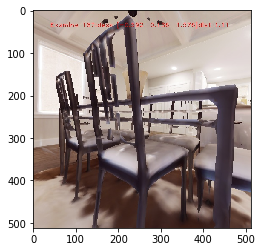

[  0   4  23  24  39  40  43  59  60  88  89  90  93  94  98 170 184 191
 221 233 240 243 261 269 292 308 311 314 318 333 336 338 348 351 424 435
 436 443 448 451 452 454 456 457 461]
4 table
23 floor
24 wall-plug
39 lamp
40 lamp
43 window
59 rug
60 lamp
88 blinds
89 major-appliance
90 countertop
93 window
94 wall
98 wall-cabinet
170 chair
191 vase
221 lamp
233 base-cabinet
240 wall
243 door
261 blinds
269 countertop
292 switch
308 door
311 lamp
314 blinds
318 wall
333 wall-cabinet
336 wall
338 base-cabinet
348 ceiling
351 chair
424 chair
435 stool
448 window
451 chair
452 chair
454 chair
456 blinds
457 blinds
461 blinds


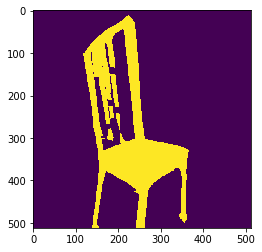

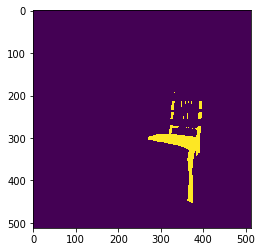

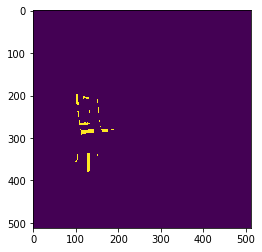

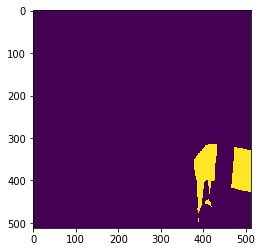

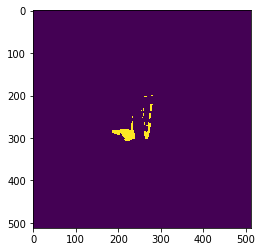

In [81]:
data_dir = '/checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/1633991019'

num_traj = 3

import os
import matplotlib.pyplot as plt
import cv2
from IPython.display import Video

# for x in range(2, num_traj):
x = 3
traj_path = os.path.join(data_dir, str(x), 'activeonly')

image_id = 237

if os.path.isdir(traj_path):
    # visualize the rgb_dbg dir
    rgb = os.path.join(traj_path, 'rgb_dbg')
    seg = os.path.join(traj_path, 'seg')
    
    image = cv2.cvtColor(cv2.imread(os.path.join(rgb, "{:05d}.jpg".format(image_id))), cv2.COLOR_BGR2RGB)
    
    prop_path = os.path.join(seg, "{:05d}.npy".format(image_id))
    annot = np.load(prop_path).astype(np.uint32)
    
    plt.imshow(image)
    plt.show()
    print(np.unique(annot))
    
    for x in np.unique(annot):
        if hsd['id_to_label'][x] in id_to_class_dict.keys():
            print(x, id_to_class_dict[hsd['id_to_label'][x]])
    # 193,404,196,172,243,133,129,170
    
    ids = [170,424,351,451,452,453]
    for x in ids:
        if x in np.unique(annot):
            binary_mask = (annot == x).astype(np.uint32)
            plt.imshow(binary_mask)
            plt.show()

In [102]:
# now for each trajectory, take these image ranges, and create a folder for each instance id with rgb, depth, robot_pos
# plug each folder into the pipeline - where we pick GT frames do label prop and train

from shutil import copyfile
import json
import os

def acopyjson(a, b, r):
    with open(a, "r") as f:
        dat = json.load(f)
    
    new_dat = {}
    ctr = 0 
    for x in range(r[0], r[1]+1):
        new_dat.update({ctr: dat[str(x)]})
        ctr += 1
    with open(b, "w") as fp:
        json.dump(new_dat, fp)


def acopydir(a, b, ext, r):
    print(f'acopydir {r}')
    if not os.path.isdir(b):
        os.makedirs(b)    
    ctr = 0
    for x in range(r[0], r[1]+1):
        f = "{:05d}{}".format(x, ext)
#         print(f)
        copyfile(os.path.join(a,f), os.path.join(b,"{:05d}{}".format(ctr, ext)))
        ctr += 1
    

data_dir = '/checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/1633991019'
out_dir = '/checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection'

traj_ranges = {
    2: [(0,32), (32,41), (69,78), (207,234), (365,389), (466,589)],
    3: [(115,173), (189,237), (334,397), (398,419)],
    4: [(64,142), (387,447), (532,558)],
    5: [(27,60), (77,93), (149,209), (210,234), (249,272), (317,409), (671,704)],
}

for traj, ranges in traj_ranges.items():
    print(traj, ranges)
    traj_dir = os.path.join(data_dir, str(traj), 'activeonly')
    for i in range(len(ranges)):
        print(i)
        traj_out = os.path.join(out_dir, str(traj), str(i))
        print(f'copying instance det {i} to {traj_out}')
        if os.path.isdir(traj_out):
            shutil.rmtree(traj_out)
        os.makedirs(traj_out)
        
        # copy rgb, seg, depth and data.json
        acopydir(os.path.join(traj_dir, 'rgb'), os.path.join(traj_out, 'rgb'), '.jpg', ranges[i])   
        acopydir(os.path.join(traj_dir, 'depth'), os.path.join(traj_out, 'depth'), '.npy', ranges[i])
        acopydir(os.path.join(traj_dir, 'seg'), os.path.join(traj_out, 'seg'), '.npy', ranges[i])
        acopyjson(os.path.join(traj_dir, 'data.json'), os.path.join(traj_out, 'data.json'), ranges[i])

2 [(0, 32), (32, 41), (69, 78), (207, 234), (365, 389), (466, 589)]
0
copying instance det 0 to /checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection/2/0
acopydir (0, 32)
acopydir (0, 32)
acopydir (0, 32)
1
copying instance det 1 to /checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection/2/1
acopydir (32, 41)
acopydir (32, 41)
acopydir (32, 41)
2
copying instance det 2 to /checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection/2/2
acopydir (69, 78)
acopydir (69, 78)
acopydir (69, 78)
3
copying instance det 3 to /checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection/2/3
acopydir (207, 234)
acopydir (207, 234)
acopydir (207, 234)
4
copying instance det 4 to /checkpoint/apratik/data_devfair0187/apartment_0/straightline/no_noise/instance_detection/2/4
acopydir (365, 389)
acopydir (365, 389)
acopydir (365, 389)
5
copying instance det 5 to /checkpoint/apr

In [42]:
sampled_ids = []
for k, v in class_ids.items():
    print(k, v)
    sampled_ids.append(random.sample(v, min(len(v),1)))
   
sampled_ids = [x for y in sampled_ids for x in y]

print(sampled_ids[:2])
    
    

    
    

chair [454, 452, 451, 426, 424, 404, 351, 133, 130, 67, 170, 172, 256]
door [437, 427, 147, 146, 139, 48, 87, 35, 71, 224, 164, 74, 220, 237, 304, 243, 308, 312, 319]
table [433, 96, 46, 4, 193]
cushion [431, 430, 400, 350, 149, 151, 205, 251, 223]
indoor-plant [392, 391, 144, 111, 100, 99, 78, 6, 152, 279]
sofa [196]
[426, 147]



  0%|          | 0/40 [00:00<?, ?it/s]

Scene apartment_0, seg dir /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/
Creating COCO annotations for 40 images 
 img_dir /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb



 50%|█████     | 20/40 [00:05<00:05,  3.44it/s]

193 in [426, 147, 193, 431, 391, 196]
adding 9 annotations
196 in [426, 147, 193, 431, 391, 196]
adding 9 annotations
431 in [426, 147, 193, 431, 391, 196]



 52%|█████▎    | 21/40 [00:05<00:05,  3.35it/s]

193 in [426, 147, 193, 431, 391, 196]
adding 9 annotations
196 in [426, 147, 193, 431, 391, 196]
adding 9 annotations
431 in [426, 147, 193, 431, 391, 196]



 55%|█████▌    | 22/40 [00:06<00:05,  3.33it/s]

193 in [426, 147, 193, 431, 391, 196]
adding 9 annotations
196 in [426, 147, 193, 431, 391, 196]
adding 9 annotations
431 in [426, 147, 193, 431, 391, 196]



 57%|█████▊    | 23/40 [00:06<00:05,  3.32it/s]

193 in [426, 147, 193, 431, 391, 196]
adding 9 annotations
196 in [426, 147, 193, 431, 391, 196]
adding 9 annotations
431 in [426, 147, 193, 431, 391, 196]



 60%|██████    | 24/40 [00:06<00:04,  3.29it/s]

193 in [426, 147, 193, 431, 391, 196]
adding 9 annotations
196 in [426, 147, 193, 431, 391, 196]
adding 9 annotations
431 in [426, 147, 193, 431, 391, 196]



 62%|██████▎   | 25/40 [00:07<00:04,  3.28it/s]

193 in [426, 147, 193, 431, 391, 196]
adding 9 annotations
196 in [426, 147, 193, 431, 391, 196]
adding 9 annotations
431 in [426, 147, 193, 431, 391, 196]



 65%|██████▌   | 26/40 [00:07<00:04,  3.27it/s]

193 in [426, 147, 193, 431, 391, 196]
adding 9 annotations
196 in [426, 147, 193, 431, 391, 196]
adding 9 annotations
431 in [426, 147, 193, 431, 391, 196]



 72%|███████▎  | 29/40 [00:08<00:03,  3.39it/s]

196 in [426, 147, 193, 431, 391, 196]
adding 9 annotations



 75%|███████▌  | 30/40 [00:08<00:02,  3.37it/s]

193 in [426, 147, 193, 431, 391, 196]
adding 9 annotations
196 in [426, 147, 193, 431, 391, 196]
adding 9 annotations



 78%|███████▊  | 31/40 [00:08<00:02,  3.38it/s]

193 in [426, 147, 193, 431, 391, 196]
adding 9 annotations
196 in [426, 147, 193, 431, 391, 196]
adding 9 annotations



 80%|████████  | 32/40 [00:09<00:02,  3.37it/s]

193 in [426, 147, 193, 431, 391, 196]
adding 9 annotations
196 in [426, 147, 193, 431, 391, 196]
adding 9 annotations



 82%|████████▎ | 33/40 [00:09<00:02,  3.38it/s]

196 in [426, 147, 193, 431, 391, 196]
adding 9 annotations



 85%|████████▌ | 34/40 [00:09<00:01,  3.35it/s]

193 in [426, 147, 193, 431, 391, 196]
adding 9 annotations
196 in [426, 147, 193, 431, 391, 196]
adding 9 annotations



 88%|████████▊ | 35/40 [00:10<00:01,  3.35it/s]

193 in [426, 147, 193, 431, 391, 196]
adding 9 annotations
196 in [426, 147, 193, 431, 391, 196]
adding 9 annotations



 90%|█████████ | 36/40 [00:10<00:01,  3.35it/s]

193 in [426, 147, 193, 431, 391, 196]
adding 9 annotations
196 in [426, 147, 193, 431, 391, 196]
adding 9 annotations



 92%|█████████▎| 37/40 [00:10<00:00,  3.37it/s]

193 in [426, 147, 193, 431, 391, 196]
adding 9 annotations
196 in [426, 147, 193, 431, 391, 196]
adding 9 annotations



 95%|█████████▌| 38/40 [00:11<00:00,  3.37it/s]

193 in [426, 147, 193, 431, 391, 196]
adding 9 annotations
196 in [426, 147, 193, 431, 391, 196]
adding 9 annotations



 98%|█████████▊| 39/40 [00:11<00:00,  3.38it/s]

193 in [426, 147, 193, 431, 391, 196]
adding 9 annotations
196 in [426, 147, 193, 431, 391, 196]
adding 9 annotations



100%|██████████| 40/40 [00:11<00:00,  3.44it/s]

193 in [426, 147, 193, 431, 391, 196]
adding 9 annotations
196 in [426, 147, 193, 431, 391, 196]
adding 9 annotations
Dumping 36 annotations to /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_instance_val1.json
36 36
save_dir /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals, coco_file_name /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_instance_val1.json
filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00000.jpg', '00000.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00000.jpg


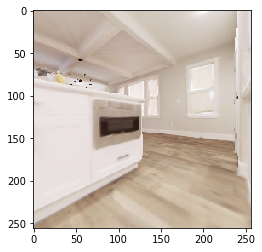

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00010.jpg', '00010.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00010.jpg


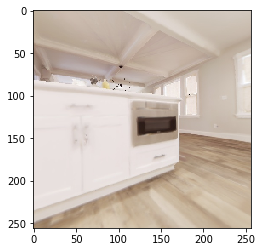

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00020.jpg', '00020.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00020.jpg


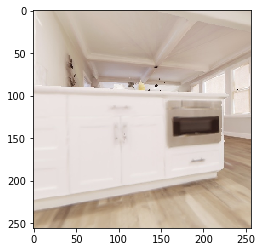

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00030.jpg', '00030.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00030.jpg


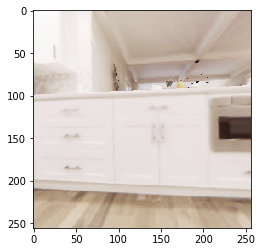

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00040.jpg', '00040.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00040.jpg


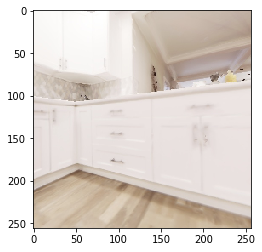

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00050.jpg', '00050.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00050.jpg


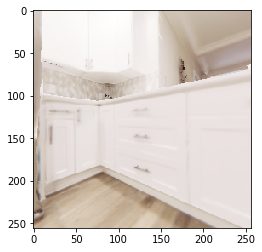

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00060.jpg', '00060.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00060.jpg


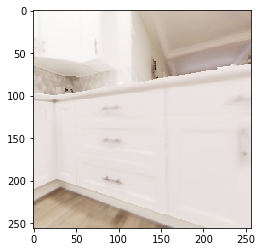

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00070.jpg', '00070.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00070.jpg


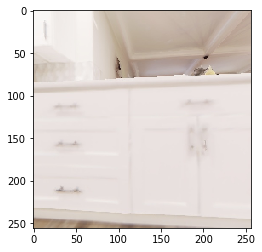

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00080.jpg', '00080.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00080.jpg


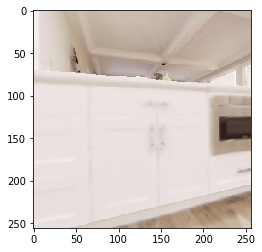

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00090.jpg', '00090.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00090.jpg


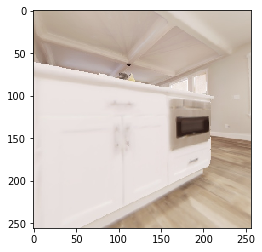

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00100.jpg', '00100.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00100.jpg


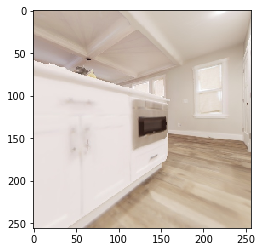

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00110.jpg', '00110.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00110.jpg


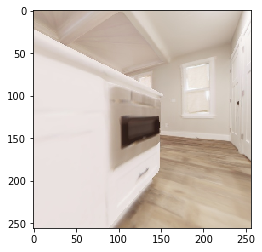

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00120.jpg', '00120.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00120.jpg


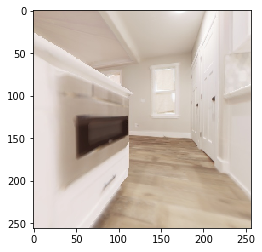

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00130.jpg', '00130.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00130.jpg


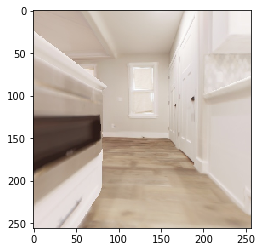

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00140.jpg', '00140.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00140.jpg


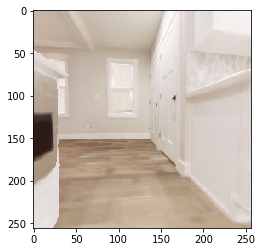

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00150.jpg', '00150.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00150.jpg


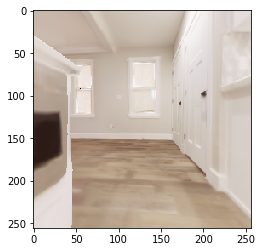

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00160.jpg', '00160.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00160.jpg


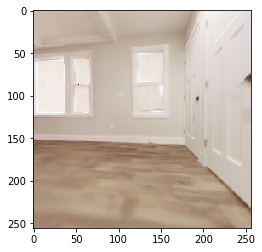

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00170.jpg', '00170.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00170.jpg


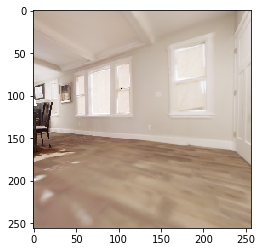

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00180.jpg', '00180.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00180.jpg


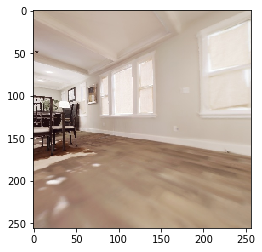

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00190.jpg', '00190.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00190.jpg


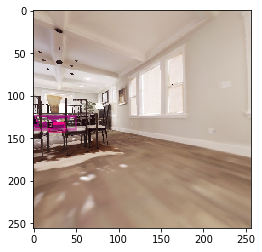

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00200.jpg', '00200.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00200.jpg


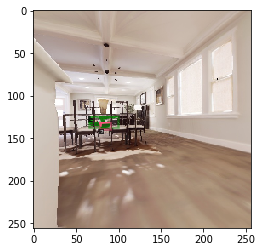

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00210.jpg', '00210.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00210.jpg


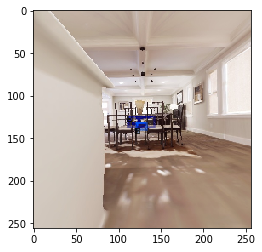

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00220.jpg', '00220.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00220.jpg


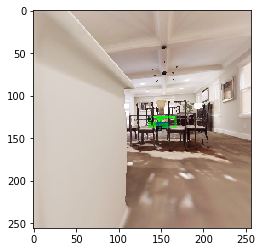

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00230.jpg', '00230.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00230.jpg


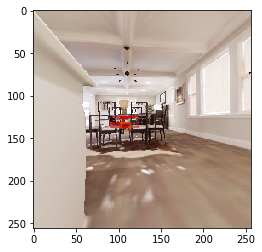

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00240.jpg', '00240.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00240.jpg


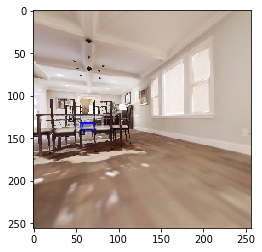

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00250.jpg', '00250.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00250.jpg


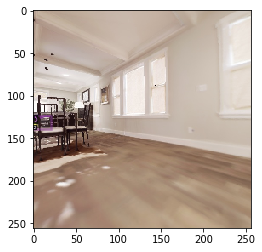

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00260.jpg', '00260.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00260.jpg


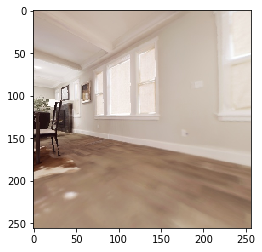

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00270.jpg', '00270.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00270.jpg


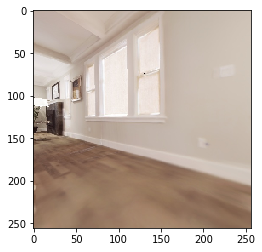

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00280.jpg', '00280.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00280.jpg


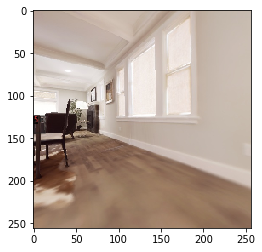

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00290.jpg', '00290.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00290.jpg


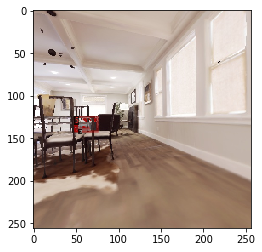

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00300.jpg', '00300.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00300.jpg


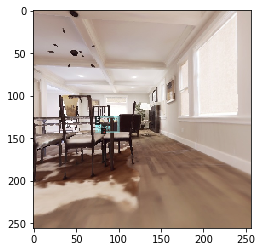

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00310.jpg', '00310.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00310.jpg


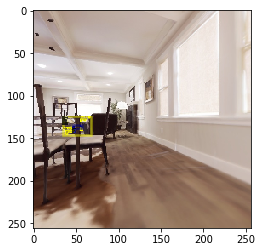

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00320.jpg', '00320.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00320.jpg


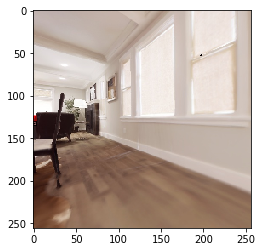

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00330.jpg', '00330.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00330.jpg


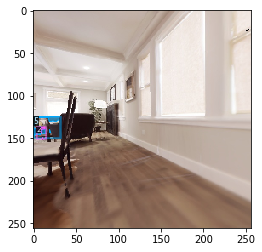

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00340.jpg', '00340.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00340.jpg


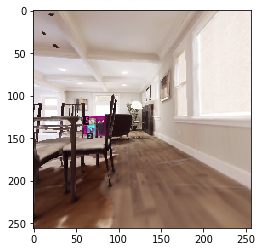

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00350.jpg', '00350.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00350.jpg


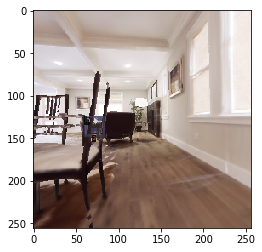

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00360.jpg', '00360.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00360.jpg


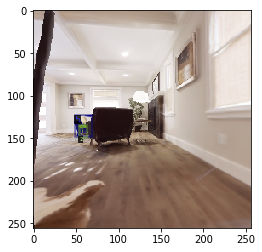

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00370.jpg', '00370.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00370.jpg


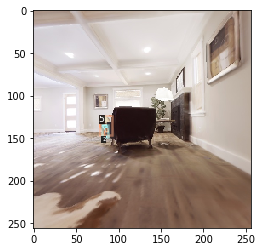

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00380.jpg', '00380.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00380.jpg


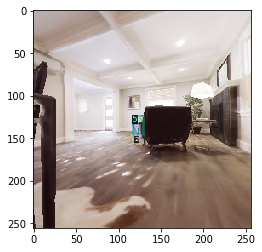

filename ('/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/rgb/00390.jpg', '00390.jpg'), visual_file /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/coco_visuals/00390.jpg


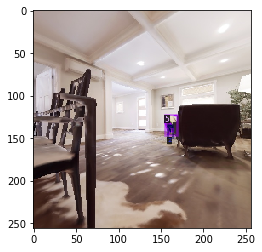

In [43]:
# Create val set

img_dir_val0 = '/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/'
out_dir = '/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/85/seg/'


run_coco(out_dir, img_dir_val0, 0.1, f'coco_instance_val1.json', sampled_ids)

In [5]:
dd = '/checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/84/seg/coco_visuals'

import subprocess
import os

scene = 'apartment_0'
heu = 'instance_test'
vid_name = scene + '_' + heu
out_f = os.path.join(os.getcwd(), f'videos/{vid_name}.mp4')
print(out_f)

/raid/apratik/droidlet/examples_and_tutorials/notebooks/active_vision/videos/apartment_0_instance_test.mp4


In [6]:
# command = f"ffmpeg -framerate 6 -f image2 -i {os.path.join(root, scene, 'rgb')}/%05d.jpg {out_f}"
command = f"ffmpeg -framerate 50 -i {dd}/*.jpg -c:v libx264 -vf 'fps=25,format=yuv420p' {out_f} -y"
# command = f"ffmpeg -f image2 -i {dd}/*.jpg out.gif"

print(command)

subprocess.call(command, shell=True)

ffmpeg -framerate 50 -i /checkpoint/apratik/data/data/apartment_0/default/no_noise/mul_traj_200/84/seg/coco_visuals/*.jpg -c:v libx264 -vf 'fps=25,format=yuv420p' /raid/apratik/droidlet/examples_and_tutorials/notebooks/active_vision/videos/apartment_0_instance_test.mp4 -y


0

In [7]:
from IPython.display import Video

# Video(f"videos/finals/{vid_name}.mp4", embed=True)
Video("videos/apartment_0_instance_test.mp4", embed=True)